![PANGAEA_Banner.png](https://github.com/pangaea-data-publisher/community-workshop-material/raw/master/banner.png)

# **How to retrieve data from PANGAEA**

Version: 0.1.0<br>
By: Michael Oellermann, Kathrin Riemann-Campe<br>
Last updated: 2023-05-12

This notebook will guide you how to retrieve diverse earth- and environmental data and its metadata from the [PANGAEA data repository](https://www.pangaea.de) using Python. It uses the [PangaeaPy package](https://github.com/pangaea-data-publisher/pangaeapy), to facilitate the data download.

Run this notebook in:
* [GoogleColab](https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb): <a target="_blank" href="https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb">
  <img src="https://colab.requery.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 1. Import libraries

In [66]:
import os
import pandas as pd
!pip install openpyxl
import openpyxl

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Pangaeapy
!pip install pangaeapy # Uncomment to install pangaeapy
import pangaeapy as pan
from pangaeapy.pandataset import PanDataSet

# Web scraping
from bs4 import BeautifulSoup
from urllib.request import urlopen, urlretrieve
import json
import requests
from pandas import json_normalize

# To access genebank records
!pip install biopython # To install biopython library
from Bio import Entrez
from Bio import SeqIO
Entrez.email = "your_email@example.com"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


# 2. Query for data in PANGAEA

AIM: What data can I find for a particular topic such as a species, location or author?

This mirrors the query via the [PANGAEA website](https://pangaea.de/)

## 2.1 Simple query
Note:
* limit = the total number of datasets to be returned from query is 500.
    * To download > 500 use the offset attribute e.g. pan.PanQuery("Triticum", limit = 500, offset=500)
* type: 
    * parent = data collection
    * child = data set as part of a data collection 
* score: Indicates how well the dataset matched the query term

In [67]:
# query database for Helgoland Roads
query = pan.PanQuery("Triticum")
print(f'There have been {query.totalcount} query results')
# Save query as dataframe
query_results = pd.DataFrame(query.result)
query_results.head(4)

There have been 604 query results


URI      score  \
0  doi:10.1594/PANGAEA.886727  18.515598   
1  doi:10.1594/PANGAEA.886725  18.173956   
2  doi:10.1594/PANGAEA.875032  16.411674   
3  doi:10.1594/PANGAEA.875037  15.870983   

                                                html    type  position  
0  <li><div class="citation"><a href="https://doi...  member         0  
1  <li><div class="citation"><a href="https://doi...  member         1  
2  <li><div class="citation"><a href="https://doi...  member         2  
3  <li><div class="citation"><a href="https://doi...  member         3

## 2.2 More complex queries

[More information](https://wiki.pangaea.de/wiki/PANGAEA_search) how to query with keywords


Multiple query terms

In [68]:
# Finds datasets that contain both "marine" and "geology"
query = pan.PanQuery("CPO")
print(f'There have been {query.totalcount} query results')

There have been 27 query results


Optional query terms

In [69]:
# Find datasets that contain "Globigerina" and either "falconensis" or "bulloides" 
query = pan.PanQuery("grain boundaries")
print(f'There have been {query.totalcount} query results')

There have been 1443 query results


Uncertain spelling

In [70]:
# Finds datasets with uncertain spelling of single letter
query = pan.PanQuery("A?tarctic")
print(f'There have been {query.totalcount} query results')

There have been 19560 query results


In [76]:
# Finds datasets with "Neogloboquadrina" regardless of your spelling mistake
query = pan.PanQuery("~Glacial~flow~")
print(f'There have been {query.totalcount} query results') 

There have been 32 query results


Specific author

In [72]:
#  	Finds datasets of author "Herzschuh"
query = pan.PanQuery("citation:author:Kerch")
print(f'There have been {query.totalcount} query results') 

There have been 23 query results


Within geolocation

In [73]:
# query database for "Deep-sea Sponge Microbiome Project" within a certain geolocation
query = pan.PanQuery("Globigerina bulloides", limit = 500, bbox=(17.7, 67.7, 21, 69))
print(f'There have been {query.totalcount} query results')

There have been 30 query results


## 2.3 Queries exceeding 500 results

### Function to query Pangaea without limited results

In [74]:
# Function to query pangaea for datasets
# This function overcomes the limit of 500 datasets
def query_pangaea(query_term = "", limit = 500, exclude_collection = True):
    query = pan.PanQuery(query_term, limit = limit)
    print(f'{query.totalcount} total query results. Query limited to {limit} results.')

    # Save query as dataframe
    query_results = pd.DataFrame(query.result)
    
    # Constrain query to limit
    if limit:
        query.totalcount = limit

    # if more than 500 query increase the offset to overcome data download limit
    if query.totalcount > 500:
        for offset in range(500, int(query.totalcount), 500):
            # new query with increased offset
            query = pan.PanQuery(query_term, offset=offset, limit = 500)
            # Attach further query results
            query_results = pd.concat([query_results, pd.DataFrame(query.result)])

    # Exclude data collection (parents) if true
    if exclude_collection:        
        query_results = query_results[query_results.type == "child"]
        print(f'{len(query_results)} child datasets extracted')

    # Delete redundant columns
    query_results = query_results.drop(["html", "position"], axis = 1)

    # Add query term to table
    query_results["query_term"] = query_term
    
    return query_results.reset_index(drop=True)

Perform query

In [75]:
# Perform PANGAEA query
query_term = "citation:author:Kerch"
query_results = query_pangaea(query_term, limit = 50, exclude_collection=False)
query_results.head(50)

23 total query results. Query limited to 50 results.


URI      score        type             query_term
0   doi:10.1594/PANGAEA.887686  29.099556      member  citation:author:Kerch
1   doi:10.1594/PANGAEA.888026  28.420864      member  citation:author:Kerch
2   doi:10.1594/PANGAEA.887919  28.385162      member  citation:author:Kerch
3   doi:10.1594/PANGAEA.888030  28.385162      member  citation:author:Kerch
4   doi:10.1594/PANGAEA.887922  28.376220      member  citation:author:Kerch
5   doi:10.1594/PANGAEA.885082  26.054035  collection  citation:author:Kerch
6   doi:10.1594/PANGAEA.888519  23.685486      member  citation:author:Kerch
7   doi:10.1594/PANGAEA.887838  22.755978  collection  citation:author:Kerch
8   doi:10.1594/PANGAEA.945806  22.489536      member  citation:author:Kerch
9   doi:10.1594/PANGAEA.933049  21.783329      member  citation:author:Kerch
10  doi:10.1594/PANGAEA.888518  21.782476      member  citation:author:Kerch
11  doi:10.1594/PANGAEA.949248  21.782475      member  citation:author:Kerch
12  doi:10.1594/PANGAEA.957032  21.782475      member  citation:author:Kerch
13  doi:10.1594/PANGAEA.888517  21.782475      member  citation:author:Kerch
14  doi:10.1594/PANGAEA.864228  21.337890      member  citation:author:Kerch
15  doi:10.1594/PANGAEA.864226  21.337890      member  citation:author:Kerch
16  doi:10.1594/PANGAEA.887691  21.337890      member  citation:author:Kerch
17  doi:10.1594/PANGAEA.887684  21.316936      member  citation:author:Kerch
18  doi:10.1594/PANGAEA.885079  21.311523      member  citation:author:Kerch
19  doi:10.1594/PANGAEA.888520  20.687252      member  citation:author:Kerch
20  doi:10.1594/PANGAEA.885078  20.240582      member  citation:author:Kerch
21  doi:10.1594/PANGAEA.885080  20.240582      member  citation:author:Kerch
22  doi:10.1594/PANGAEA.864227  18.618526      member  citation:author:Kerch

### Add Pangaea ID (optional for to much labeling)

In [78]:
#Choose one of them or all
query_results.iat[22,0] # [record, row]
#query_results.pangaea_id

'doi:10.1594/PANGAEA.864227'

# 3. Download datasets

## 3.1 Download single dataset

AIM: How can I download a single dataset right into Python or to my harddrive?

### Search for datasets like you dit above

### Download dataset from PANGAEA

Using the url from Query above and guess which one isnt 404 or gives an output like (OPEN),
Directory listings for /Projects/Colle_Gnifetti/ are disabled by the server administrator!

In [79]:
ds = PanDataSet(query_results.iat[2,0]) #you migth choose s.th. and use full URL as string
print(ds.data)

                   Event           Sample label                  File name  \
0   Chli-Titlis_Profile1        Titlis_1-10a_li        Titlis_1-10a_li.bmp   
1   Chli-Titlis_Profile1        Titlis_1-10a_re        Titlis_1-10a_re.bmp   
2   Chli-Titlis_Profile1        Titlis_1-10b_li        Titlis_1-10b_li.bmp   
3   Chli-Titlis_Profile1        Titlis_1-10b_re        Titlis_1-10b_re.bmp   
4   Chli-Titlis_Profile1         Titlis_1-11_li         Titlis_1-11_li.bmp   
5   Chli-Titlis_Profile1         Titlis_1-11_re         Titlis_1-11_re.bmp   
6   Chli-Titlis_Profile1         Titlis_1-9a_li         Titlis_1-9a_li.bmp   
7   Chli-Titlis_Profile1         Titlis_1-9a_re         Titlis_1-9a_re.bmp   
8   Chli-Titlis_Profile1         Titlis_1-9b_li         Titlis_1-9b_li.bmp   
9   Chli-Titlis_Profile1         Titlis_1-9b_re         Titlis_1-9b_re.bmp   
10  Chli-Titlis_Profile1    Titlis_1-B1-side_li    Titlis_1-B1-side_li.bmp   
11  Chli-Titlis_Profile1    Titlis_1-B1-side_re    Titlis_1-B1-s

Using the doi

In [92]:
ds = PanDataSet(query_results.iat[20,0])
ds.data

Height  δ18O H2O                 Event  Latitude  Longitude  Date/Time
0     1.87    -14.10  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
1     1.67    -14.38  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
2     1.49    -14.91  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
3     1.29    -12.40  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
4     1.09    -15.25  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
5     0.91    -13.96  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
6     0.76    -15.70  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
7     0.58    -14.40  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
8     0.41    -12.58  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
9     0.37    -13.30  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
10    0.33    -13.15  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
11    0.29    -12.35  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
12    0.25    -15.10  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
13    0.23    -14.49  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
14    0.21    -13.64  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
15    0.19    -13.36  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
16    0.17    -13.42  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
17    0.15    -13.99  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
18    0.13    -14.16  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
19    0.11    -13.96  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
20    0.09    -14.02  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
21    0.07    -13.94  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
22    0.05    -10.52  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
23    0.04    -10.82  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
24    0.03    -10.79  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
25    0.02    -10.86  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01
26    0.01    -10.90  Chli-Titlis_Profile1  46.77085    8.42346 2014-01-01

Using the PANGAEA ID

ds = PanDataSet(923033) #add the index above
print(ds.data.head(3))

### Translate to long parameter names
Because by default parameters are abbreviated without units

In [100]:
# Translate short parameters names to long names including unit
def get_long_parameters(ds):
    """Translate short parameters names to long names including unit

    Args:
        ds (PANGAEA dataset): PANGAEA dataset
    """
    ds.data.columns =  [f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()]

print(ds.data.columns[:10])
get_long_parameters(ds)
ds.data.columns[:10]

Index(['HEIGHT above ground [m]', 'δ18O, water [‰ SMOW]', 'Event',
       'Latitude [deg]', 'Longitude [deg]', 'Date/Time'],
      dtype='object')


Index(['HEIGHT above ground [m]', 'δ18O, water [‰ SMOW]', 'Event',
       'Latitude [deg]', 'Longitude [deg]', 'Date/Time'],
      dtype='object')

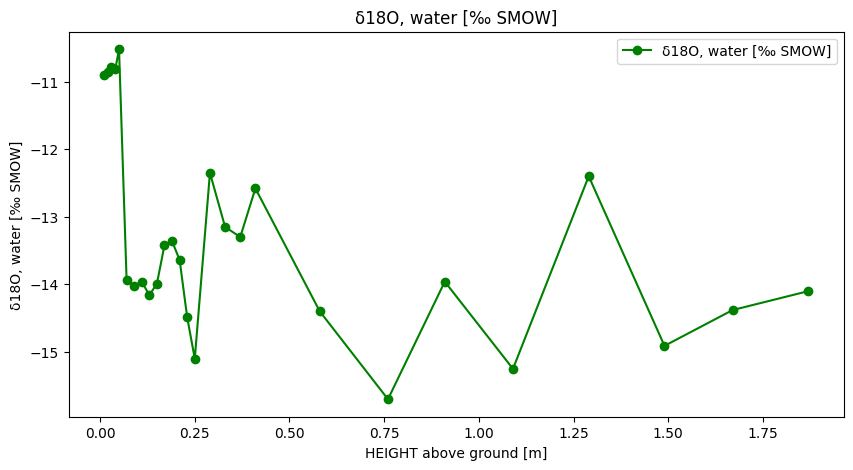

In [119]:
ds.data
ds.data.plot(x='HEIGHT above ground [m]', y='δ18O, water [‰ SMOW]', figsize=(10,5),  color='green', marker='o')

# Set the x-axis label
plt.xlabel('HEIGHT above ground [m]')

# Set the y-axis label
plt.ylabel('δ18O, water [‰ SMOW]')

# Set the title of the plot
plt.title('δ18O, water [‰ SMOW]')

# Display the plot
plt.show()

### Display location of dataset samples

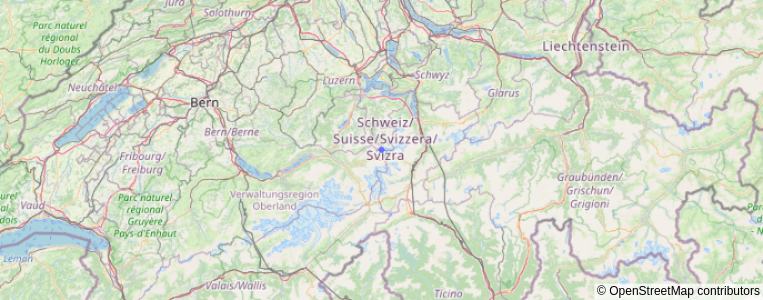

In [120]:
# Plot sampling points on interactive plotly map
fig = px.scatter_mapbox(ds.data, lat="Latitude [deg]", lon="Longitude [deg]", 
                        #hover_name="Event label", 
                        hover_data=['Latitude [deg]', 'Longitude [deg]', 'HEIGHT above ground [m]', 'δ18O, water [‰ SMOW]', 'Event'], 
                        zoom=7, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Save data

In [121]:
# Create data folder
data_folder = "pangaea_data"
# Check if it already exists before creating it
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)
# Save to csv
print(f'PANGAEA dataset {ds.id} saved')
ds.data.to_csv(os.path.join(data_folder, f'Pangaea_dataset_{ds.id}.csv'))

PANGAEA dataset 885078 saved
